<div id="colab_button">
  <h1>Data visualization</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.7/docs/docs/tutorials/visualization.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
__________________________________________________________________________

Data visualization methods such as graphs and charts can be a great tool to help make data more accessible and tell the stories hidden in numbers. 

Our implementations of key visualization methods focus on privacy. We extract data only when it's truly necessary for the visualization function, and we perform remote aggregation before extracting data where possible. This works in addition to all the other safety benefits and features, such as data access policies.

In this tutorial, we'll introduce the **data visualization functions** available in BastionLab and see **how to use them** with our `RemoteLazyFrame` object.

## Pre-requisites
___________________________________________

### Installation and dataset

In order to run this notebook, we need to:
- Have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/)
- Download [the dataset](https://www.kaggle.com/competitions/titanic) we will be using in this tutorial.

We'll do so by running the code block below. 

>If you are running this notebook on your machine instead of [Google Colab](https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.6/docs/docs/tutorials/data_cleaning.ipynb), you can see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) to find the installation method that best suits your needs.

In [3]:
# pip packages
!pip install -e ../../../client
#!pip install bastionlab
#!pip install bastionlab_server

# download the dataset
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

Obtaining file:///home/laura/bl2/client
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for bastionlab (pyproject.toml) ... done
  Created wheel for bastionlab: filename=bastionlab-0.3.7-0.editable-py3-none-any.whl size=1567 sha256=4a2d9554cf55c881d12b10960d7d47ae52ec7cd193432d3dff7f965bd66e2e76
  Stored in directory: /tmp/pip-ephem-wheel-cache-nszbl76v/wheels/5f/f2/47/e53d32d52680ed8f46efc519f7e8121bf0f76fa9d0bc7f9561
Successfully built bastionlab
  Attempting uninstall: bastionlab
    Found existing installation: bastionlab 0.3.7
    Uninstalling bastionlab-0.3.7:
      Successfully uninstalled bastionlab-0.3.7
--2023-01-24 15:31:37--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubuserco

Our dataset is based on the Titanic dataset, one of the most popular datasets used for understanding machine learning which contains information relating to the passengers aboard the Titanic. 

### Launch and connect to the server

In [9]:
# launch bastionlab_server test package
import bastionlab_server

srv = bastionlab_server.start()

BastionLab server (version 0.3.7) already installed
Libtorch (version 1.13.1) already installed
TLS certificates already generated
Bastionlab server is now running on port 50056


[2023-01-24T14:51:03Z INFO  bastionlab] Authentication is disabled.
[2023-01-24T14:51:03Z INFO  bastionlab] Telemetry is enabled.
[2023-01-24T14:51:03Z INFO  bastionlab] Successfully loaded saved dataframes
[2023-01-24T14:51:03Z INFO  bastionlab] BastionLab server listening on 0.0.0.0:50056.
[2023-01-24T14:51:03Z INFO  bastionlab] Server ready to take requests
Error: transport error

Caused by:
    0: error creating server listener: Address already in use (os error 98)
    1: Address already in use (os error 98)


>*Note that the bastionlab_server package we install here was created for testing purposes. You can also install BastionLab server using our Docker image or from source (especially for non-test purposes). Check out our [Installation Tutorial](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) for more details.*

In [10]:
# connect to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Upload the dataframe to the server


We'll quickly upload the dataset to the server with an open safety policy, since setting up BastionLab is not the focus of this tutorial. It will allows us to demonstrate features without having to approve any data access requests. You can check out how to define a safe privacy policy [here](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/defining_policy_privacy/).

In [11]:
import polars as pl
from bastionlab.polars.policy import Policy, TrueRule, Log

df = pl.read_csv("titanic.csv")
policy = Policy(safe_zone=TrueRule(), unsafe_handling=Log(), savable=True)
rdf = client.polars.send_df(df, policy=policy)

rdf

FetchableLazyFrame(identifier=141da082-f295-43fb-91ef-84f56cdae00b)


<div class="admonition warning">
    <p class="admonition-title">Important!</p>
    <p class=""><b>This policy is not suitable for production.</b> Please note that we <i>only</i> use it for demonstration purposes, to avoid having to approve any data access requests in the tutorial. <br></p>
    </div><br>

Since we are using the classic Titanic dataset, let's list the columns to verify we got the right dataset and give you an idea of the data we will be handling in this tutorial.

In [4]:
rdf.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

## Histplot
_____________________________________________________________________

Now, let's take a look at the first of our data visualization options, `histplot`.

The `histplot()` function accepts `x` and `y` arguments, which are strings referring to a column name, plus a `bins` integer value, which is set to 10 by default. You must provide either an `x` or `y` argument, the rest is optional. We also accept any `kwargs` arguments accepted by Seaborn's `barplot` function, when you supply only an `X` or `Y` argument, or `heatmap` function, when you supply both `X` and `Y` arguments (this is possible because we call these function internally once we have ran the relevant aggregated query and applied bins to our dataframe.) 

>Accepted options are listed in [Seaborn's barplot documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html) and [Seaborn's Heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

Let's take a look at an example. Here, we create a histogram to show the number of passengers in each age category, with bins of 15.

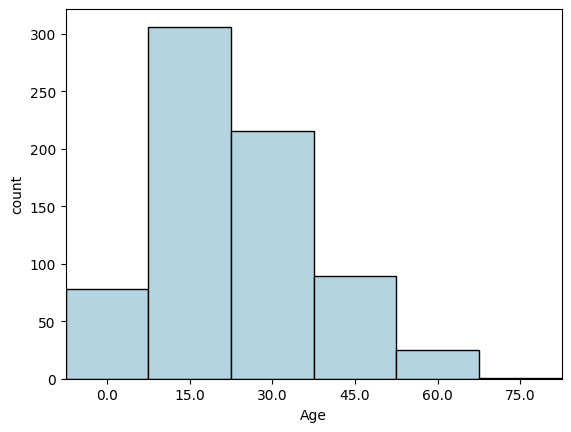

In [8]:
rdf.histplot(x="Age", bins=15)

If we provide an `x` and `y` value, this will internally make use of Seaborn's `heatmap` function.

>Accepted options are listed in [Seaborn's heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

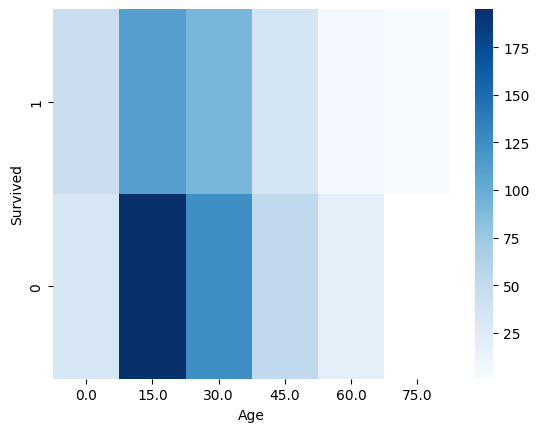

In [9]:
rdf.histplot(x="Age", y="Survived", bins=15)

## Barplot
_____________________________________________________________________

The `barplot` function filters data down to necessary columns only, runs an aggregated query to get the mean (or other estimator function) `y` value for the `x` axes, and then calls Seaborn's barplot function to draw the barchart, forwarding on just this aggregated and filtered down dataset.

`barplot()` requires `x` and `y` values, which are strings referring to a column name. it also accepts an optional `estimator` string argument, where you can change the default estimator (`"mean"`) to any of the following estimators: `"median"`, `"count"`, `"max"`, `"min"`, `"std"` and `"sum"`. There is also an optional `hue` argument where you can specify the name of a column you want to be used to group results by. We also accept any `kwargs` arguments accepted by Seaborn's barplot function. 

>Accepted options are listed in [Seaborn's barplot documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html).

Here, we create histogram to show the number of passengers in each age category, with bins of 15:

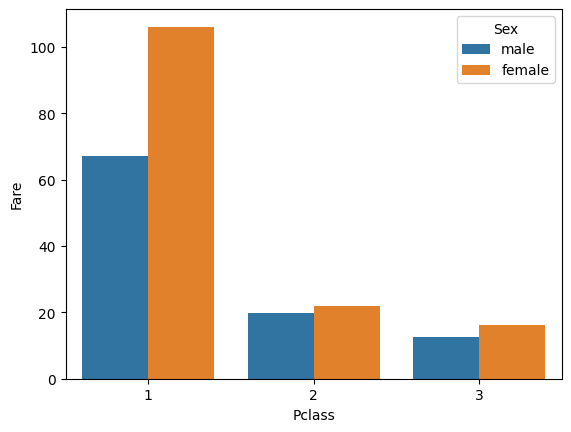

In [10]:
rdf.barplot(x="Pclass", y="Fare", hue="Sex")

## Scatterplot
________________________________________________________________________________

The `scatterplot` function plot will display a scatter diagram based on x and y arguments which can be used to look for correlations between x and y columns. 

`scatterplot()` requires `x` and `y` string arguments referring to the name of the columns to be used for the x and y axes in the scatterplot.

It will first narrow down the `RemoteLazyFrame` to the necessary columns to make the function call, before calling Seaborn's `scatterplot` function to plot your scatter graph.

This function also accepts the same `optional arguments` as Seaborn's scatterplot function as `kwargs`.
> You can find those in [Seaborn's scatterplot documentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).

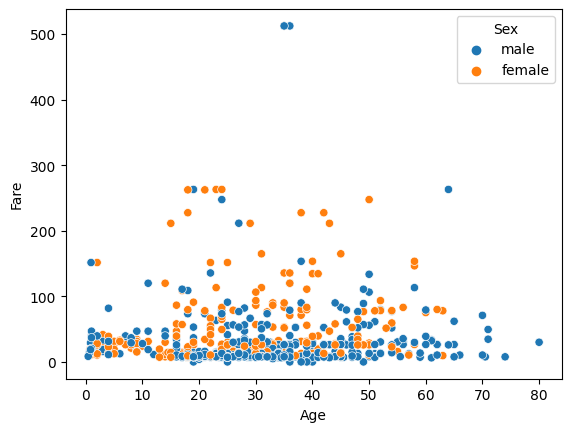

In [11]:
rdf.scatterplot("Age", "Fare", hue="Sex")

## Lineplot
________________________________________________________________________________

The `lineplot` function filters our dataframe down to necessary columns only and then draws a line graph using Seaborn's `lineplot` function.

`lineplot()` requires `x` and `y` string arguments that refer to the names of columns to be used for the x and y axes. 

It also accepts `hue`, `size` and `string` arguments. The arguments are the names of the columns to be used as grouping variables which will produce lines with different
colors, widths and dashes and/or markers respectively. 

Additionally, lineplot accepts a `units` argument which is the name of a column to be used as a grouping variable identifying sampling units. Note that you must also set the `estimator` keyword to `None` if you wish to use the `units` argument.

Finally, the function also accepts the same `optional arguments` as Seaborn's `lineplot` function as `**kwargs`. 
>You can find those in [Seaborn's lineplot documentation](https://seaborn.pydata.org/generated/seaborn.lineplot.html).

Let's have a look at an example.


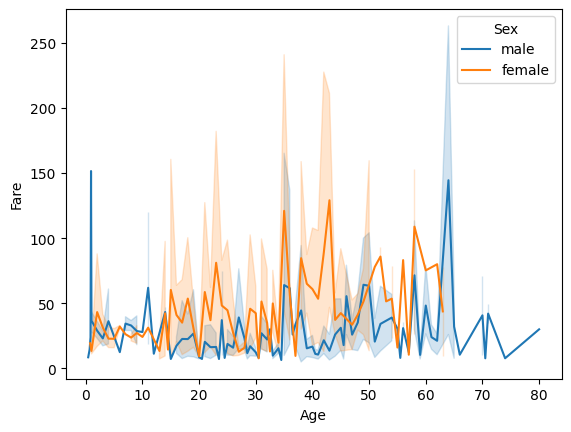

In [12]:
rdf.lineplot(x="Age", y="Fare", hue="Sex")

## Boxplot
________________________________________________________________________________

The `boxplot` function filters our dataframe down to necessary columns only and then draws a boxplot (also known as a box-and-whisker plot) using Seaborn's `boxplot` function.

`boxplot()` has optional `x`, `y` and `hue` string arguments that refer to the names of columns to be used for the x and y axes. However, there must be at least an `x` or a `y` argument supplied!

There is also a `with_outlier` argument, which determines if outliers should be included in the output. This is set to `True` by default. We will discuss this option in more detail at the end of this section.
 
Additionally, `boxplot` accepts the same `optional arguments` as Seaborn's `boxplot` function as `**kwargs`. 
>You can find those in [Seaborn's boxplot documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

Let's take a look at an example using a single `y` argument, `fare`. The boxplot shows the minimum, maximum, 1st quartile and 3rd quartile of the `fare` paid on the titanic.

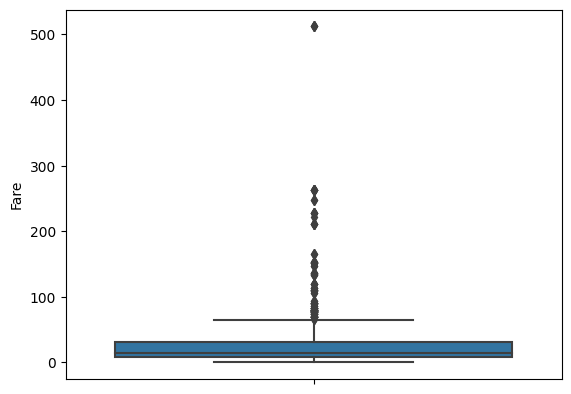

In [5]:
rdf.boxplot(y="Fare")

The first time we do this, we see there are multiple outliers which are negatively impacting the visualization. We can therefore use the clip function to filter out some of these outlier values.

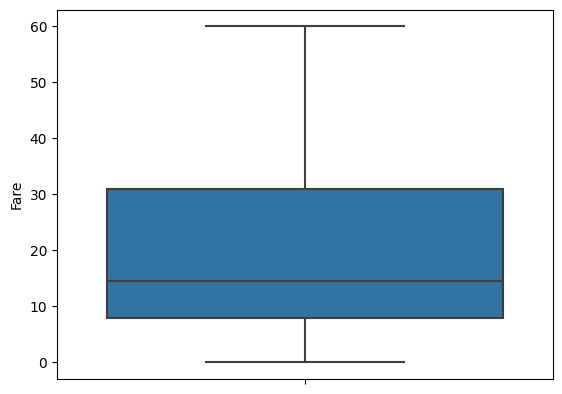

In [6]:
clipped = rdf.select(pl.col("Fare").clip(min_val=0, max_val=60))
clipped.boxplot(y="Fare")

Let's now look at an example using the `x` and `y` arguments to see the minimum, maximum, 1st quartile and 3rd quartile values for `fare` per each passenger class on the Titanic.

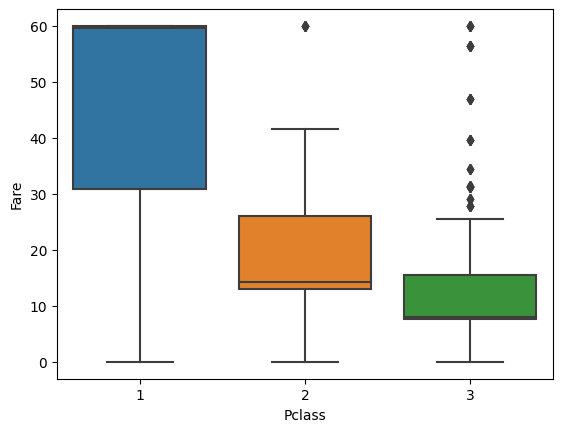

In [12]:
clipped = rdf.select([pl.col("Fare").clip(min_val=0, max_val=60), pl.col("Pclass")])
clipped.boxplot(y="Fare", x="Pclass")

We can also view this information horizontally, simply by using the 'orient' kwargs keyword and setting it to `h`.

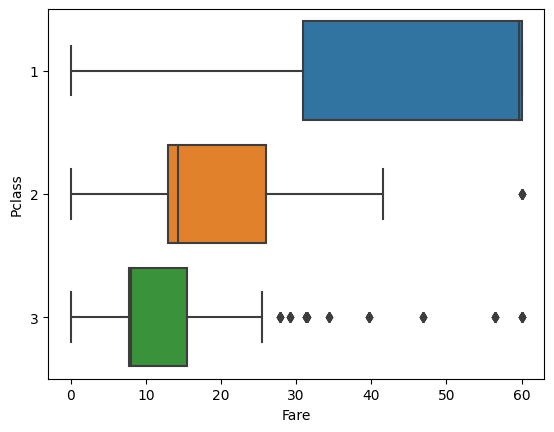

In [13]:
clipped.boxplot(y="Pclass", x="Fare", orient="h")

### With or without outliers?

The final topic we need to cover before we move onto the next visualization function is the `with_outliers` option.

This boolean argument determines if outliers will be included in our visualization. However, it has notable implications for the privacy policy.

In order to use boxplot with outliers, we have to extract the relevant columns from the server in full, which may be blocked by the security policy (depending on the security rules in place). 

However, if we set `with_outliers` to False, we are able to create our boxplot using aggregated queries only, so this is highly unlikely to be in breach of any security policies.

Therefore, we recommend setting `with_outliers` to False whenever you don't specifically need to view outliers or whenever you are working with a dataset with a strict security policy.

Let's check out the previous query with `with_outliers` set to False.

In [ ]:
clipped.boxplot(y="Pclass", x="Fare", orient="h", with_outliers=False)

## Pieplot
________________________________________________________________________________

The `pieplot` functions draws a pie chart where segment values are stored in one column and labels are provided. We calculate each individual cell in the column as a percentage of the sum of values in that column before calling Matplotlib's [pie function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html).

This is particularly useful after running aggregated queries, which will become clear in the following example, but first, let's take a look at the arguments `pieplot()` takes:

- An mandatory `parts` string argument, which is the name of the column containing the values for each segment in the pie chart.
- A `Title` string argument.
- A `labels` argument, which is either the name of the column containing labels values, or a List[str] of the labels. In both cases, the order of the labels should follow the same order as the values in the `parts` column.
- An `ax` argument, which allows you to send your own matplotlib axis if required. Note that if you do this, the following `fig_kwargs` arguments will not be used.
- A `fig_kwargs` dictionary argument, which is where you can add any `kwargs` you wish to be forwarded onto `matplotlib.pyplot.subplots()` when creating the figure that this piechart will be displayed on.
- A `pie_labels` boolean value, which you can modify to `False` if you do not with to label the segments of your pie chart.
- A `key` boolean value, where you can specify if you want a color map key placed to the side of your pie chart.
- The `key_loc`, `key_title` and `key_bbox` options, where you can specify the location, title and bbox options for your color map key. These are forwarded on to matplotlib's legend function.

Now, let's take a look at an example of where we might use `pieplot`. We will run an aggregated query to get the number of deceased per passenger class on the Titanic.

We first filter the dataset to those who did not survive the Titanic, then we select all necessary columns and group data by Pclass, before we get a count of values per each class and sort the output by `Pclass`.

We can then call our `pieplot` function on this dataset specifying the "Survived" column as our `parts` argument, a title for our pie chart and the `"Class"` column to be used for labelling, to get our pie chart.

[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on 51d6e168-f5d5-4cd0-abcb-d3579aa72bd4
[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on a2ae61fc-b61a-4c96-b3a7-137299a92984
[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on f0461ed7-2750-4869-8a83-914ddd2b72f1


shape: (3, 2)
┌────────┬──────────┐
│ Pclass ┆ Survived │
│ ---    ┆ ---      │
│ i64    ┆ u32      │
╞════════╪══════════╡
│ 1      ┆ 80       │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 2      ┆ 97       │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
│ 3      ┆ 372      │
└────────┴──────────┘


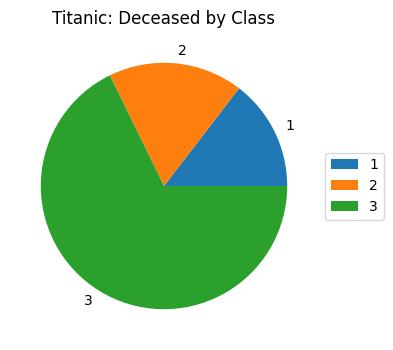

In [ ]:
rdf_ex = (
    rdf.filter(pl.col("Survived") == 0)
    .select([pl.col("Survived"), pl.col("Pclass")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").count())
    .sort(pl.col("Pclass"))
)
print(rdf_ex.collect().fetch())
rdf_ex.pieplot(parts="Survived", title="Titanic: Deceased by Class", labels="Pclass")

## Facet grid plots
_______________________________________________________________________________________________________________

The `facet` function lets you create a grid of plots that accepts a `col` and `row` argument. You can then call the `histplot`, `scatterplot` or `curveplot` functions to decide how you want to plot your data in the columns and rows of the grid. 

For example, if you have a Facet with a row value of `"Pclass"` and you call `my_facet.histplot(x="Age", bins=15)`, you will see three histplots: one showing the age of passengers in class 1, one for passengers in class 2 and the final one for class 3.

Before we continue any further, let's see the code for this example:

[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on fcf8787f-412b-43ab-9be4-15379eed5322
[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on 21bfee38-0641-4b67-b5ed-3e66a74ade7b
[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on 419ab635-c1a9-4039-90aa-2e5044a81d3c
[2023-01-17T15:13:58Z INFO  bastionlab_polars] Succesfully ran query on 21a0e346-1fdc-43ca-bb8a-620984f73d02


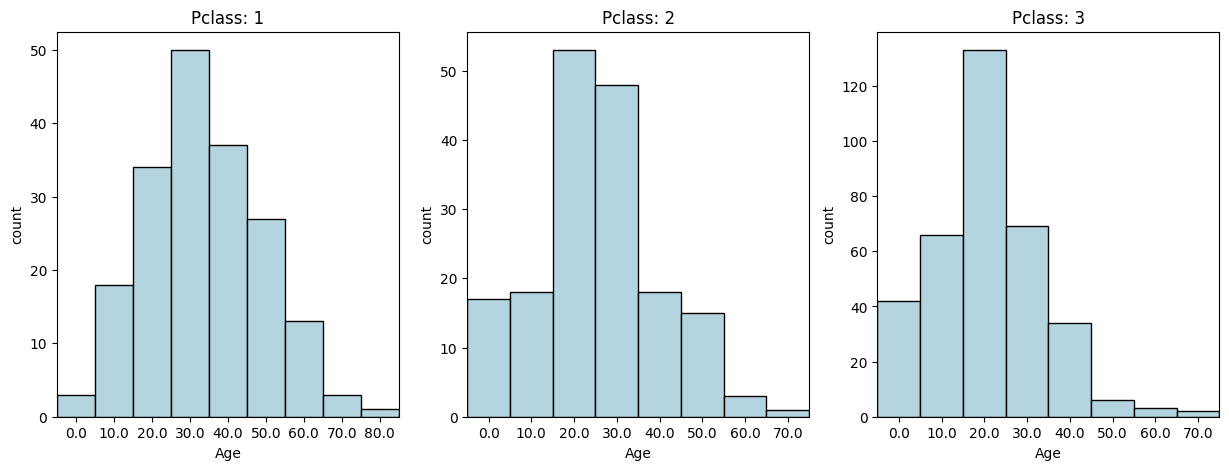

In [ ]:
my_facet = rdf.facet(col="Pclass")
my_facet.histplot(x="Age")

Now that we have seen an example with a row, let's add a column! We will also specify the `figsize`, the size of the figure we want for our grid.

[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on 756cb783-d5ea-4347-8c38-fd840e7e16f6
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on fcee97b9-1548-4635-bae8-c30028190af7
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on 30aa5e51-b38f-4b3e-bb03-d71dd3b313c4
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on d7e51c92-620e-446d-910d-82b8a849cb46
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on 0f7e772c-24d7-48bc-963d-7b99db964a54
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on 149bed36-1957-4ea4-839e-b11996128554
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on 243495c1-5a8a-46fa-ba65-e5c7d8df617e
[2023-01-17T15:14:00Z INFO  bastionlab_polars] Succesfully ran query on 17ee9b1b-5933-480e-a2a5-e76099a21d98


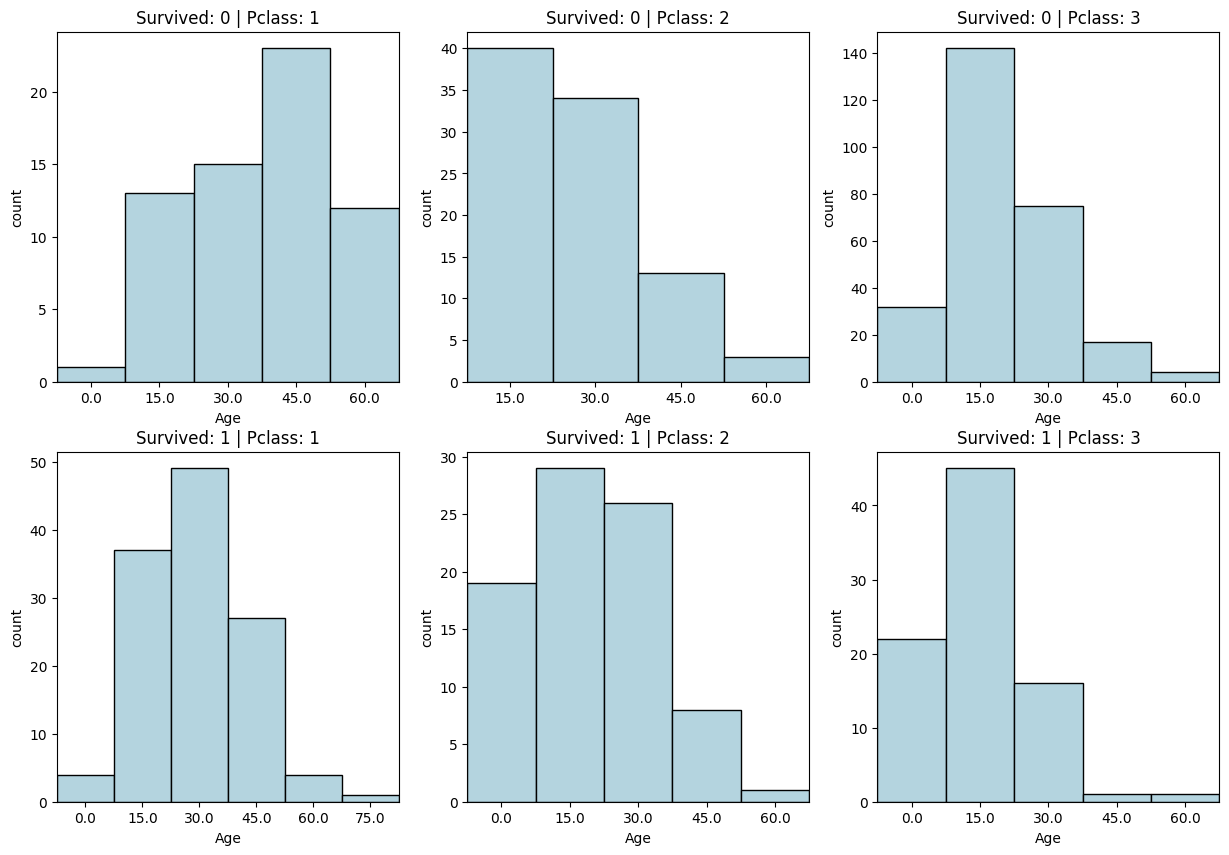

In [ ]:
new_facet = rdf.facet(col="Pclass", row="Survived", figsize=(15, 10))
new_facet.histplot(x="Age", bins=15)

The grid now splits results into all the possible combinations of the column and row values.

As previously mentioned, this feature works with all the visualization functions except for the pieplot function. 

>**Important note**: the `hue`, `size` `string` and `units` keywords cannot be used for `lineplot` when using `facet`. 

Here's a facet grid with `scatterplot()`, for example:


[2023-01-17T15:14:02Z INFO  bastionlab_polars] Succesfully ran query on 1f2b5c81-f577-41ee-86f8-1fbbec5db195
[2023-01-17T15:14:02Z INFO  bastionlab_polars] Succesfully ran query on a5ac7aa6-4619-41aa-93d6-2b00ea6c1553
[2023-01-17T15:14:02Z INFO  bastionlab_polars] Succesfully ran query on 289cf561-dd69-47fe-b057-a54bc091c1c6
[2023-01-17T15:14:03Z INFO  bastionlab_polars] Succesfully ran query on 2e5b1641-6582-43b2-87bd-6b1dfc14ade6
[2023-01-17T15:14:03Z INFO  bastionlab_polars] Succesfully ran query on 0a2ba101-851d-40e1-9db7-a490c2de0daf
[2023-01-17T15:14:03Z INFO  bastionlab_polars] Succesfully ran query on 5e138cd8-1130-4128-b0ad-368f945faeab
[2023-01-17T15:14:03Z INFO  bastionlab_polars] Succesfully ran query on 97b5bf3e-1551-4484-81b0-ce792aff14ed
[2023-01-17T15:14:03Z INFO  bastionlab_polars] Succesfully ran query on e4ab5200-6fd5-4b0f-a31e-e1e935945d88


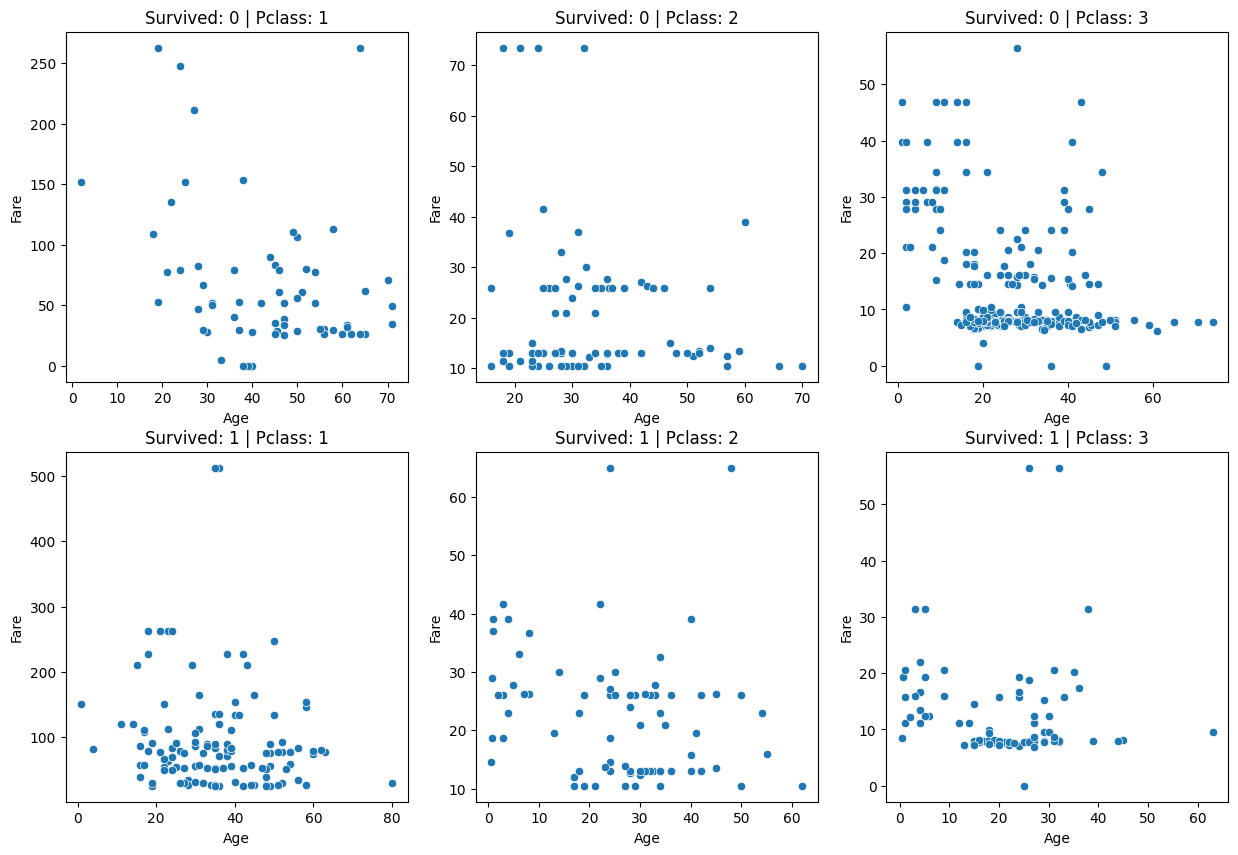

In [ ]:
new_facet = rdf.facet(col="Pclass", row="Survived")
new_facet.scatterplot(x="Age", y="Fare")

That's it! As our last step, we'll close the connection to the server.

In [ ]:
connection.close()
bastionlab_server.stop(srv)